# Tutorial 3: DBit-Seq Mouse Embryo RNA and Protein Multi-Omics Data

We applied COSMOS to a spatially resolved RNA-Protein multi-omics dataset. This dataset contains 1,789 spatially resolved cells from E10 mouse embryo brain regions with a joint profiling of 22 proteins and 254 genes with DBiT-seq.

The raw data can be downloaded from: 
https://figshare.com/articles/dataset/Spatial_genomics_datasets/21623148/5


In [1]:
import pandas as pd
import numpy as np
import scanpy as sc# Tutorial 2: ATAC-RNA-Seq Mouse Brain RNA and ATAC Multi-Omics Data
import matplotlib
import matplotlib.pyplot as plt
from umap import UMAP
import sklearn
import seaborn as sns
import h5py
from COSMOS import cosmos
from COSMOS.pyWNN import pyWNN 
import warnings
warnings.filterwarnings('ignore')
random_seed = 20

/Applications/anaconda3/envs/spaceflow_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##  Preparation of data

### Importing the data

In [2]:
data_mat = h5py.File('./DBiT_Seq Mouse Embryo_RNA_Protein.h5', 'r')
df_data_RNA = np.array(data_mat['X_gene']).astype('float64')     # gene count matrix
df_data_protein = np.array(data_mat['X_protein']).astype('float64')  # protein count matrix
loc = np.array(data_mat['pos']).astype('float64') 
gene_names = list(data_mat['gene'])
gene_names = [gene.decode("utf-8") for gene in gene_names]
protein_names = list(data_mat['protein'])
protein_names = [protein.decode("utf-8") for protein in protein_names]
protein_names = [protein.split(".")[0] for protein in protein_names]

### Preprocessing of the data

In [3]:
adata1 = sc.AnnData(df_data_RNA, dtype="float64")
adata1.index = gene_names
sc.pp.normalize_per_cell(adata1)
sc.pp.log1p(adata1)

adata2 = sc.AnnData(df_data_protein, dtype="float64")
adata2.index = protein_names
sc.pp.log1p(adata2)


adata1.obsm['spatial'] = np.array(loc)
adata1.obs['x_pos'] = np.array(loc)[:,0]
adata1.obs['y_pos'] = np.array(loc)[:,1]


adata2.obsm['spatial'] = np.array(loc)
adata2.obs['x_pos'] = np.array(loc)[:,0]
adata2.obs['y_pos'] = np.array(loc)[:,1]

## Applying COSMOS to integrate RNA and Protein omics

In [4]:
## COSMOS training 
cosmos_comb = cosmos.Cosmos(adata1=adata1,adata2=adata2)
cosmos_comb.preprocessing_data(n_neighbors = 10)
cosmos_comb.train(spatial_regularization_strength=0.05, z_dim=50, 
         lr=1e-3, wnn_epoch = 500, total_epoch=1000, max_patience_bef=10, max_patience_aft=30, min_stop=200, 
         random_seed=random_seed, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000)
weights = cosmos_comb.weights
df_embedding = pd.DataFrame(cosmos_comb.embedding)

Epoch 1/1000, Loss: 1.4152836799621582
Epoch 11/1000, Loss: 1.3764169216156006
Epoch 21/1000, Loss: 1.2355204820632935
Epoch 31/1000, Loss: 1.0089517831802368
Epoch 41/1000, Loss: 0.7810782194137573
Epoch 51/1000, Loss: 0.5532382726669312
Epoch 61/1000, Loss: 0.39876386523246765
Epoch 71/1000, Loss: 0.2744125723838806
Epoch 81/1000, Loss: 0.20421990752220154
Epoch 91/1000, Loss: 0.14220260083675385
Epoch 101/1000, Loss: 0.09400250762701035
Epoch 111/1000, Loss: 0.07774685323238373
Epoch 121/1000, Loss: 0.0801333636045456
Epoch 131/1000, Loss: 0.0642048567533493
Epoch 141/1000, Loss: 0.04826752468943596
Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 1789 0.01 seconds elapsed
Selecting top K neighbors
Epoch 151/1000, Loss: 0.14596854150295258
Epoch 161/1000, Loss: 0.07289119064807892
Epoch 171/1000, Loss: 0.05306774377822876
Epoch 181/1000, Loss: 0.0

### Clustering of COSMOS integration

In [5]:
def screen_res(df_embedding, n_cluster = 5, res_s = 0.1, res_e = 1.0, step = 0.1):
    opt_res = res_s
    opt_clusters = n_cluster
    for res in np.arange(res_s,res_e,step):
        embedding_adata = sc.AnnData(df_embedding)
        sc.pp.neighbors(embedding_adata, n_neighbors=50, use_rep='X')
        sc.tl.leiden(embedding_adata, resolution=float(res))
        clusters = list(embedding_adata.obs["leiden"])
        cluster_num = len(np.unique(clusters))
        print('res = ' + str(round(res, 2)) + ', Cluster# = ' + str(cluster_num))
        if cluster_num == n_cluster:
            opt_res = res
            opt_clusters = clusters
    print('optimal res = ' + str(round(opt_res, 2)))
    return opt_res, opt_clusters

# Screening resolution that matches the given number of clusters 
opt_res_cosmos, opt_clusters_cosmos = screen_res(df_embedding,res_s = 0.4, res_e = 0.7, step = 0.02,n_cluster = 10)

res = 0.4, Cluster# = 8
res = 0.42, Cluster# = 9
res = 0.44, Cluster# = 9
res = 0.46, Cluster# = 11
res = 0.48, Cluster# = 10
res = 0.5, Cluster# = 10
res = 0.52, Cluster# = 10
res = 0.54, Cluster# = 10
res = 0.56, Cluster# = 10
res = 0.58, Cluster# = 10
res = 0.6, Cluster# = 11
res = 0.62, Cluster# = 10
res = 0.64, Cluster# = 12
res = 0.66, Cluster# = 12
res = 0.68, Cluster# = 12
optimal res = 0.62


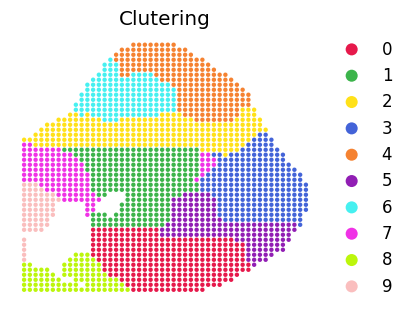

In [6]:
# Plotting figures

adata_new = adata1.copy()
adata_new.obs['Cluster_cosmos'] = opt_clusters_cosmos
adata_new.obs["Cluster_cosmos"]=adata_new.obs["Cluster_cosmos"].astype('category')

matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(4,3.5))
sz = 40
plot_color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']

domains="Cluster_cosmos"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Clutering'
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
ax.axes.invert_yaxis()

### UMAP visualization of COSMOS integration

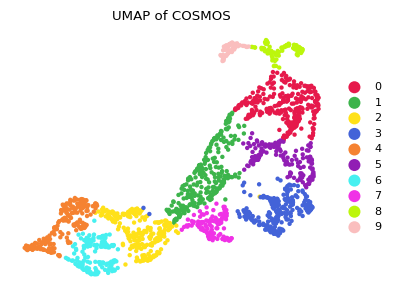

In [7]:
# UMAP visualization
umap_2d = UMAP(n_components=2, init='random', random_state=random_seed, min_dist = 0.3,n_neighbors=30)
umap_pos = umap_2d.fit_transform(df_embedding)
adata_new.obs['cosmos_umap_pos_x'] = umap_pos[:,0]
adata_new.obs['cosmos_umap_pos_y'] = umap_pos[:,1]

# Ploting figures
plot_color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
matplotlib.rcParams['font.size'] = 8.0
fig, axes = plt.subplots(1, 1, figsize=(4,3))
sz = 40
domains="Cluster_cosmos"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'UMAP of COSMOS'
ax=sc.pl.scatter(adata_new,alpha=1,x="cosmos_umap_pos_x",y="cosmos_umap_pos_y",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
plt.tight_layout()


### Showing modality weights of two omics in COSMOS integration

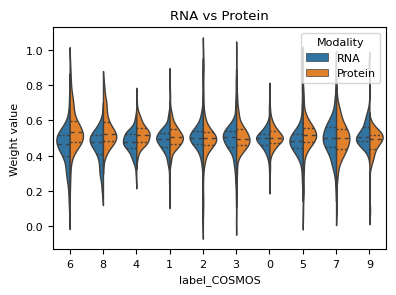

In [8]:
layer_labels = opt_clusters_cosmos
labels_uniq = np.unique(layer_labels)
labels = [i for i in range(len(np.unique(layer_labels)))]
index_all = [np.array([i for i in range(len(layer_labels)) if layer_labels[i] == labels_uniq[0]])]
for k in range(1,len(labels)):
    temp_idx = np.array([i for i in range(len(layer_labels)) if layer_labels[i] == labels_uniq[k]])
    index_all.append(temp_idx)    

wghts_mean = np.mean(weights[index_all[0],:],0)
for k in range(1,len(labels_uniq)):
    wghts_mean_temp = np.mean(weights[index_all[k],:],0)
    wghts_mean = np.vstack([wghts_mean, wghts_mean_temp])
df_wghts_mean = pd.DataFrame(wghts_mean,columns = ['w1','w2'],index = labels_uniq)

def plot_weight_value(alpha, label, modality1='RNA', modality2='Protein',order = None):
    df = pd.DataFrame(columns=[modality1, modality2, 'label'])  
    df[modality1], df[modality2] = alpha[:, 0], alpha[:, 1]
    df['label'] = label
    df = df.set_index('label').stack().reset_index()
    df.columns = ['label_COSMOS', 'Modality', 'Weight value']
    matplotlib.rcParams['font.size'] = 8.0
    fig, axes = plt.subplots(1, 1, figsize=(4,3))
    ax = sns.violinplot(data=df, x='label_COSMOS', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1, show=False, orient = 'v', order=order)
    ax.set_title(modality1 + ' vs ' + modality2) 

    plt.tight_layout(w_pad=0.05)

df_sort_mean = df_wghts_mean.sort_values(by=['w1'])
plot_weight_value(weights, np.array(adata_new.obs['Cluster_cosmos']), order = list(df_sort_mean.index))

